In [2]:
#Torch and torchvision imports 
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
'''
Used to convert the image to a tensor
A tensor is an algebraic object that describes a multilinear relationship between sets of algebraic objects related to a vector space.
The tensor is then normalised (setting values between 0 and 1)
'''
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#Importing the test and train datasets and applies the transformation
trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transform)
testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform)

#DataLoader wraps an iterable around the Dataset to enable easy access to the samples
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 4, shuffle = True, num_workers = 2)
testloader = torch.utils.data.DataLoader(testset, batch_size = 4, shuffle = True, num_workers = 2)

#Classes of the target variable (y) instead of having a 0 - 9 
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


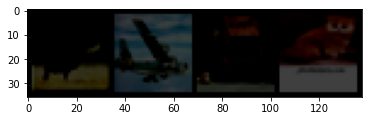

 deer plane truck   cat


In [4]:
import matplotlib.pyplot as plt
import numpy as np
'''
Function to plot the images (Not sure why they are so dark)
'''
def imshow(img):
    img = img / 2 * 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#These lines iterate over the dataset to take a sample of data i.e the picture and its lables
dataiter = iter(trainloader)
images, lables = dataiter.next()

imshow(torchvision.utils.make_grid(images))

#Printing the lables of the pictures
print(' '.join('%5s' % classes[lables[j]] for j in range(4)))

In [6]:
import torch.nn as nn
import torch.nn.functional as F
'''
Creating the neural network function using torch's neural network (nn) class.
Creating a Neural Netowrk object by extending the torch.nn.Module base class
'''
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() #For extending torch.nn
        #Max pooling layer (Calculates the maximum value in each patch of each feature map,
        #highlights the most present feature in the patch)
        self.pool = nn.MaxPool2d(2,2)

        '''
        Convolution and liniar layers
        kernel_size, out_channels and out_features values are chosen arbitrarily, 
        This means that we choose the values mainly based on trial and error and utilising values that have proven to work in the past
        

        kernel_size: Sets the filter size, the words kernel and filter are interchangable,
        kernel_size is actually a tupple this is because our filters actually have a height and width,
        and when we pass a single number,the code inside the layer's constructor assumes that we want a square filter.

        out_channels: Sets the number of filters. One filter produces one output channel
        
        out_features: Sets the sixe of the output tensor

        in_channels in the first convolutional layer is based on the number of colour channels in the data (1 for greyscale.etc)
        out_features of the final Liniar layer must be the number of classes in the training set
        in_features of the first Liniar layer has the *4*4 as we need to flatten the data from the last convolutional layer

        The inuput of one layer is the output of the previous layer
        
        Learnable parameters
        Learnable parameters are parameters whose values are learned during the training process.

        With learnable parameters, we typically start out with a set of arbitrary values,
        and these values then get updated in an iterative fashion as the network learns.
        '''
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        

        #Liniar layers (the fc stands for fully connected as this is another name for Liniar layers)
        self.fc1 = nn.Linear(in_features = 16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
    
    '''
    fowaard function, a tensor flowing foward through the nn is known as a foward pass.
    Each layer has its own transformation and the tensor passes foward through each layer's transformation
    '''

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
for epoch in range(2):
    running_loss = 0.0
    for i , data in enumerate(trainloader, 0):
        inputs, labels = data
        
        optimizer.zero_grad()

        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f'%
            (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

cpu
[1,  2000] loss: 2.178
[1,  4000] loss: 1.818
[1,  6000] loss: 1.673
[1,  8000] loss: 1.548
[1, 10000] loss: 1.524
[1, 12000] loss: 1.476
[2,  2000] loss: 1.390
[2,  4000] loss: 1.368
[2,  6000] loss: 1.357
[2,  8000] loss: 1.319
[2, 10000] loss: 1.296
[2, 12000] loss: 1.295
Finished Training


In [9]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


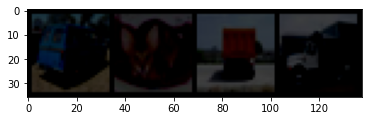

Ground Truth:    car   cat truck truck


In [10]:
dataiter = iter(testloader)
images, lables = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('Ground Truth: ', ' '.join('%5s' % classes[lables[j]] for j in range(4)))

In [11]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [12]:
outputs = net(images)

In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:  truck   cat horse truck


In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, lables = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total +=lables.size(0)
        correct += (predicted==lables).sum().item()

print(correct)
print("accuracy of the network on test images: %d %%" %(100 * correct/ total))

5515
accuracy of the network on test images: 55 %


In [ ]:
#this is a test change